In [3]:
import torch
from transformers import *
import numpy as np
import csv

In [4]:
model_name = 'bert-base-multilingual-uncased'
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [5]:
def extract_lang_mapping(short_names, tokenizer):
    # get mapping from ISO to language names (based on north_euralex)
    # remove languages whose names are longer than a single token
    mapping = {}
    with open("../data/northeuralex-0.9-language-data.tsv") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0] != "name":
                language = row[0]
                if language in short_names:
                    language = short_names[language]
                if len(language.split()) > 1:
                    continue
                if len(tokenizer.tokenize(language)) > 1:
                    continue
                iso = row[2]
                mapping[iso] = language
    return mapping


short_names = {"Modern Hebrew": "Hebrew", "Modern Greek": "Greek", "Western Farsi": "Farsi",
            "Standard Albanian": "Albanian", "Standard Arabic": "Arabic", "Norwegian (Bokmål)": "Norwegian"}
mapping = extract_lang_mapping(short_names, tokenizer)

In [6]:
print(mapping)

{'fin': 'Finnish', 'ekk': 'Estonian', 'hun': 'Hungarian', 'ben': 'Bengali', 'hin': 'Hindi', 'pes': 'Farsi', 'hye': 'Armenian', 'ell': 'Greek', 'sqi': 'Albanian', 'bul': 'Bulgarian', 'hrv': 'Croatian', 'slk': 'Slovak', 'ces': 'Czech', 'pol': 'Polish', 'ukr': 'Ukrainian', 'rus': 'Russian', 'lit': 'Lithuanian', 'lav': 'Latvian', 'nor': 'Norwegian', 'swe': 'Swedish', 'dan': 'Danish', 'deu': 'German', 'nld': 'Dutch', 'eng': 'English', 'gle': 'Irish', 'cym': 'Welsh', 'bre': 'Breton', 'lat': 'Latin', 'fra': 'French', 'cat': 'Catalan', 'spa': 'Spanish', 'por': 'Portuguese', 'ita': 'Italian', 'ron': 'Romanian', 'tur': 'Turkish', 'tat': 'Tatar', 'ket': 'Ket', 'kor': 'Korean', 'jpn': 'Japanese', 'kan': 'Kannada', 'mal': 'Malayalam', 'tam': 'Tamil', 'tel': 'Telugu', 'kat': 'Georgian', 'eus': 'Basque', 'lbe': 'Lak', 'arb': 'Arabic', 'heb': 'Hebrew'}


In [7]:
def extract_north_euralex(mapping):

    words = {}
    with open("../data/northeuralex-0.9-forms.tsv") as f_words:
        reader = csv.reader(f_words, delimiter="\t")
        for row in reader:
            if row[0] not in mapping:
                continue
            lang = mapping[row[0]]
            concept = row[2]
            word = row[3]
            if concept not in words:
                words[concept] = []
            words[concept].append((word, lang))

    all_translations = {}
    for concept in words:
        translations = {}
        for pair in words[concept]:
            w, lang = pair
            translations[lang] = w
        
        all_translations[concept] = translations

    return all_translations


all_translations = extract_north_euralex(mapping)

In [8]:

def get_predictions(sentence, k=10):
    
    prefix, mask, suffix = sentence.split("***")
    prefix_tokens = tokenizer.tokenize(prefix)
    suffix_tokens = tokenizer.tokenize(suffix)
    tokens = ['[CLS]'] + prefix_tokens + ['[MASK]'] + suffix_tokens + ['[SEP]']
    input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokens)])
    target_idx = len(prefix_tokens) + 1

    prediction_scores = model(input_ids)[0][0]
    token_scores = prediction_scores[target_idx].detach().cpu().numpy()
    best_k = (np.argsort(token_scores))[-k:][::-1]
    
    return tokenizer.convert_ids_to_tokens(best_k)



In [9]:
from collections import Counter
from tqdm import tqdm_notebook
import pickle

template = "The word '{}' in ***mask*** is: {}."

count = Counter()
avg = Counter()
acc1 = Counter()
acc5 = Counter()
acc10 = Counter()
details = []
i = 0
confusion = {}
for concept in tqdm_notebook(all_translations):
    translations = all_translations[concept]
    en_word = all_translations[concept]["English"]

    #if i > 100:
    #    break
            
    for lang, foreign_word in translations.items():
        if lang == "English":
            continue
        lang = lang.lower()
        sentence = template.format(en_word, foreign_word)
        preds = get_predictions(sentence)
        
        details.append((en_word, lang, foreign_word, preds))
        
        if lang not in confusion:
            confusion[lang] = []
        confusion[lang].append(preds[0])
        
        count[lang] += 1
        
        i += 1
            
        if lang in preds:
            rank = preds.index(lang)
            avg[lang] += rank
            if rank == 0:
                acc1[lang] += 1
            if rank < 5:
                acc5[lang] += 1
            if rank < 10:
                acc10[lang] += 1
        else:
            avg[lang] += 10
            
for lang in count:
    avg[lang] = avg[lang]/float(count[lang])

for lang in confusion:
    confusion[lang] = Counter(confusion[lang])
    

for lang in count:
    acc1[lang] = acc1[lang]/float(count[lang])
    acc5[lang] = acc5[lang]/float(count[lang])
    acc10[lang] = acc10[lang]/float(count[lang])
    
    
print(avg)
print(acc1)
print(acc5)
print(acc10)

with open("../data/translator_langs_details", "wb") as f:
    pickle.dump(details, f)

/home/hila/anaconda3/envs/mbert/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



Counter({'ket': 10.0, 'lak': 10.0, 'farsi': 9.969488188976378, 'tatar': 9.715551181102363, 'georgian': 9.10728346456693, 'slovak': 9.034448818897637, 'romanian': 8.836614173228346, 'latvian': 8.76968503937008, 'breton': 8.704225352112676, 'albanian': 7.698818897637795, 'czech': 7.5265748031496065, 'basque': 7.485236220472441, 'croatian': 7.311330049261084, 'norwegian': 7.209852216748769, 'catalan': 6.719488188976378, 'estonian': 6.353346456692913, 'lithuanian': 6.339566929133858, 'armenian': 6.32051282051282, 'hungarian': 6.065944881889764, 'danish': 5.900492610837438, 'tamil': 5.718503937007874, 'hindi': 5.409448818897638, 'swedish': 4.927165354330708, 'bulgarian': 4.693978282329714, 'welsh': 4.637795275590551, 'malayalam': 4.427165354330708, 'bengali': 4.400985221674877, 'irish': 4.28698224852071, 'portuguese': 4.171259842519685, 'turkish': 4.163385826771654, 'telugu': 4.06003937007874, 'finnish': 3.813976377952756, 'kannada': 3.4921259842519685, 'polish': 2.802165354330709, 'ukrain

In [10]:
dict(acc10)

{'finnish': 0.7480314960629921,
 'hungarian': 0.49311023622047245,
 'bengali': 0.7458128078817734,
 'hindi': 0.7746062992125984,
 'armenian': 0.5877712031558185,
 'greek': 1.0,
 'bulgarian': 0.8153998025666338,
 'russian': 0.9980314960629921,
 'lithuanian': 0.5068897637795275,
 'norwegian': 0.39507389162561574,
 'swedish': 0.6919291338582677,
 'danish': 0.5674876847290641,
 'german': 0.9911417322834646,
 'dutch': 0.9645669291338582,
 'irish': 0.76232741617357,
 'welsh': 0.6801181102362205,
 'latin': 0.9585798816568047,
 'french': 0.9921259842519685,
 'spanish': 0.8779527559055118,
 'portuguese': 0.8080708661417323,
 'italian': 0.9468503937007874,
 'turkish': 0.7086614173228346,
 'korean': 0.9492031872509961,
 'japanese': 0.9655511811023622,
 'kannada': 0.8503937007874016,
 'malayalam': 0.7116141732283464,
 'tamil': 0.6082677165354331,
 'telugu': 0.8188976377952756,
 'arabic': 0.984251968503937,
 'hebrew': 0.9901574803149606,
 'estonian': 0.5098425196850394,
 'albanian': 0.3228346456692

In [11]:
sorted_acc1 = {k: v for k, v in sorted(acc1.items(), key=lambda item: item[1], reverse=True)}
all_results = []
for lang in sorted_acc1:
    all_results.append(acc1[lang])
    all_results.append(acc5[lang])
    all_results.append(acc10[lang])
all_results = np.array(all_results)
all_results = all_results.reshape(47,3)
np.save("../data/results_predict_langs", all_results)
    

In [12]:
import pickle
with open("../data/translator_langs_details", "wb") as f:
    pickle.dump(details, f)

In [13]:
list_reverse = [item[0] for item in avg.most_common()][::-1]
print(list_reverse)

['greek', 'russian', 'hebrew', 'arabic', 'french', 'german', 'japanese', 'korean', 'latin', 'italian', 'dutch', 'spanish', 'ukrainian', 'polish', 'kannada', 'finnish', 'telugu', 'turkish', 'portuguese', 'irish', 'bengali', 'malayalam', 'welsh', 'bulgarian', 'swedish', 'hindi', 'tamil', 'danish', 'hungarian', 'armenian', 'lithuanian', 'estonian', 'catalan', 'norwegian', 'croatian', 'basque', 'czech', 'albanian', 'breton', 'latvian', 'romanian', 'slovak', 'georgian', 'tatar', 'farsi', 'lak', 'ket']


In [14]:
most_accurate_langs = [item[0] for item in acc1.most_common(20)]
print(most_accurate_langs)

['greek', 'russian', 'arabic', 'hebrew', 'german', 'japanese', 'korean', 'french', 'latin', 'polish', 'italian', 'spanish', 'finnish', 'turkish', 'dutch', 'welsh', 'swedish', 'hungarian', 'portuguese', 'danish']


In [15]:
for lang in most_accurate_langs:
    print(lang, "&", format(acc1[lang], '.3f'), "&", format(acc5[lang], '.3f'), "&", format(acc10[lang], '.3f'), "\\\\ \hline")

greek & 0.986 & 0.998 & 1.000 \\ \hline
russian & 0.943 & 0.994 & 0.998 \\ \hline
arabic & 0.794 & 0.963 & 0.984 \\ \hline
hebrew & 0.761 & 0.968 & 0.990 \\ \hline
german & 0.758 & 0.951 & 0.991 \\ \hline
japanese & 0.716 & 0.939 & 0.966 \\ \hline
korean & 0.664 & 0.905 & 0.949 \\ \hline
french & 0.637 & 0.976 & 0.992 \\ \hline
latin & 0.626 & 0.900 & 0.959 \\ \hline
polish & 0.576 & 0.728 & 0.803 \\ \hline
italian & 0.572 & 0.873 & 0.947 \\ \hline
spanish & 0.503 & 0.757 & 0.878 \\ \hline
finnish & 0.404 & 0.622 & 0.748 \\ \hline
turkish & 0.399 & 0.589 & 0.709 \\ \hline
dutch & 0.315 & 0.846 & 0.965 \\ \hline
welsh & 0.262 & 0.548 & 0.680 \\ \hline
swedish & 0.262 & 0.492 & 0.692 \\ \hline
hungarian & 0.254 & 0.395 & 0.493 \\ \hline
portuguese & 0.236 & 0.587 & 0.808 \\ \hline
danish & 0.231 & 0.388 & 0.567 \\ \hline


In [16]:
# I change the oreder of the langs I got so close ones are next to each other in the matrix
# old: most_accurate_langs = ['greek', 'russian', 'arabic', 'hebrew', 'german', 'japanese', 'korean', 'french', 'latin', 'polish', 'italian', 'spanish', 'finnish', 'turkish', 'dutch', 'welsh', 'swedish', 'hungarian', 'portuguese', 'danish']

most_accurate_langs = ['greek', 'russian', 'arabic', 'hebrew', 'german', 'dutch', 'swedish', 'danish', 'japanese', 'korean', 'french', 'latin', 'italian', 'spanish', 'portuguese', 'polish', 'finnish', 'turkish', 'welsh', 'hungarian']


In [17]:
idx2lang = most_accurate_langs#["english"] + most_accurate_langs
lang2idx = {l: i for i,l in enumerate(idx2lang)}

In [18]:
print(idx2lang)
print(lang2idx)

['greek', 'russian', 'arabic', 'hebrew', 'german', 'dutch', 'swedish', 'danish', 'japanese', 'korean', 'french', 'latin', 'italian', 'spanish', 'portuguese', 'polish', 'finnish', 'turkish', 'welsh', 'hungarian']
{'greek': 0, 'russian': 1, 'arabic': 2, 'hebrew': 3, 'german': 4, 'dutch': 5, 'swedish': 6, 'danish': 7, 'japanese': 8, 'korean': 9, 'french': 10, 'latin': 11, 'italian': 12, 'spanish': 13, 'portuguese': 14, 'polish': 15, 'finnish': 16, 'turkish': 17, 'welsh': 18, 'hungarian': 19}


In [19]:
confusion_clean = np.zeros((len(idx2lang), len(idx2lang)))
for lang in confusion:
    if lang not in lang2idx:
        continue
    for pred_lang, count in confusion[lang].items():
        if pred_lang in lang2idx:
            confusion_clean[lang2idx[lang],lang2idx[pred_lang]] = np.sqrt(count)

print(confusion_clean)
print(confusion_clean.shape)

[[31.65438358  2.64575131  0.          1.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          1.          0.          0.          0.          1.
   0.          0.        ]
 [ 0.         30.95157508  0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   1.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 1.41421356  5.19615242 28.40774542  4.69041576  0.          0.
   0.          0.          0.          0.          2.          1.
   0.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 3.          9.16515139  7.54983444 27.80287755  2.          0.
   1.          0.          1.73205081  1.          2.64575131  0.
   1.41421356  1.41421356  0.          2.23606798  0.          0.
   0.          1.        ]
 [ 0.          0.          1.41421356  1.41421356 27.74887385  5.19615242
   3.60555128  1.73205081 

['greek', 'russian', 'arabic', 'hebrew', 'german', 'dutch', 'swedish', 'danish', 'japanese', 'korean', 'french', 'latin', 'italian', 'spanish', 'portuguese', 'polish', 'finnish', 'turkish', 'welsh', 'hungarian']


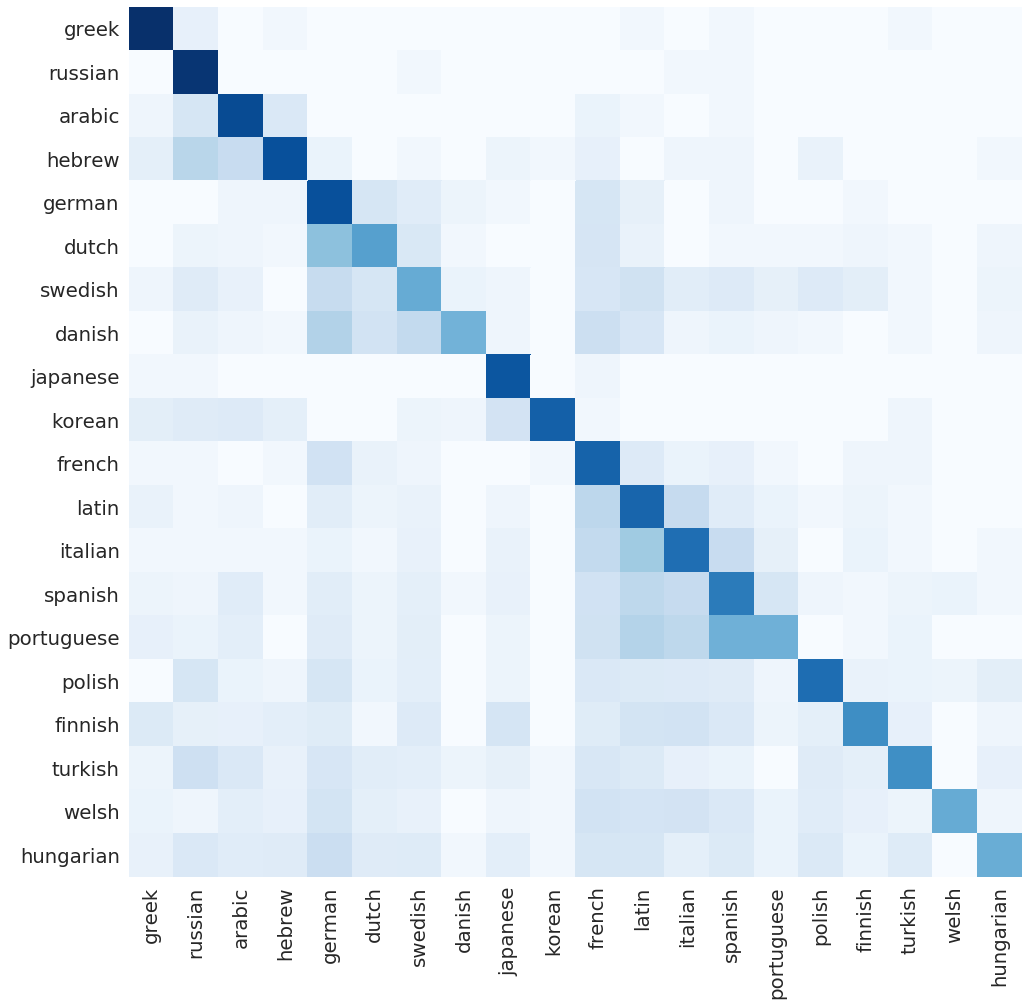

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
langs = [idx2lang[i] for i in range(len(idx2lang))]
print(langs)
df_cm = pd.DataFrame(confusion_clean, index = langs, columns = langs)
plt.figure(figsize = (16,16))
sn.set(font_scale=1.8)
sn.heatmap(df_cm, cmap="Blues", annot=False, cbar=False)

# work around to fix the bug in top and bottom lines
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.savefig("../figs/confusion_langs.pdf")